In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import image_resize, generate_lines
import plotly.graph_objects as go
from tqdm import tqdm


(7877, 784)


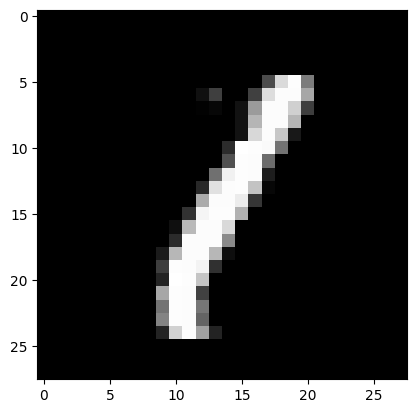

In [2]:
# Download MNIST dataset
X_mnist, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
# Normalize data
X_mnist = X_mnist / 255.0
X_mnist = X_mnist[y == '1']
print(X_mnist.shape)
plt.imshow(X_mnist[1000].reshape(28, 28), cmap='gray')

In [69]:
GRID_D = 3
grids = np.meshgrid(*[np.arange(8) for _ in range(GRID_D)])
topology = np.stack(grids, axis=-1)
print(topology.shape)

flat_topology = topology.reshape((-1, GRID_D))

print(flat_topology.shape)
K = flat_topology.shape[0]
C = np.zeros((K, K))
for ni in tqdm(range(K)):
    for nj in range(K):
        C[ni, nj] = (np.maximum(0.0, 1-np.abs(flat_topology[ni]-flat_topology[nj]).sum()/2))


(8, 8, 8, 3)
(512, 3)


100%|██████████| 512/512 [00:00<00:00, 915.85it/s]


In [70]:
C[0]

array([1. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [71]:
flat_topology

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       ...,
       [7, 7, 5],
       [7, 7, 6],
       [7, 7, 7]])

In [72]:
N = X_mnist.shape[0]
initial_center_ids = np.random.choice(N, (K,), replace=False)

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_X = torch.tensor(X_mnist, dtype=torch.float32).to(device).requires_grad_(False)
torch_C = torch.tensor(C, dtype=torch.float32).to(device).requires_grad_(False)
torch_centers = torch_X[initial_center_ids].clone().detach().to(device).requires_grad_(False)
torch.set_float32_matmul_precision('high')

In [74]:
def train(torch_X, torch_C, torch_centers, device="cpu"):
    alpha = 0.01
    iters = 1000000
    batch_size = 16

    center_to_cluster_dists = torch.cdist(torch_centers, torch_X)
    cluster_assignment = torch.argmin(center_to_cluster_dists, axis=0)
    loss = ((torch_centers[cluster_assignment] - torch_X)**2).sum()
    print (f"Iteration: 0, Loss: {loss.item()}")

    for i in tqdm(range(iters)):
        sampled_x = torch_X[torch.randint(N, (batch_size,), device=device, requires_grad=False)]
        cluster_id = torch.argmin(torch.cdist(torch_centers, sampled_x), axis=0)
        cluster_alpha = (alpha * torch_C[cluster_id]).unsqueeze(-1)
        torch_centers = ((1 - cluster_alpha) * torch_centers + cluster_alpha * sampled_x.unsqueeze(1)).mean(axis=0)
        # every 10% of the iterations, print the loss
        if i % (iters // 20) == 0 and i > 0:
            center_to_cluster_dists = torch.cdist(torch_centers, torch_X)
            cluster_assignment = torch.argmin(center_to_cluster_dists, axis=0)
            loss = ((torch_centers[cluster_assignment] - torch_X)**2).sum()
            print (f"Iteration: {i}, Loss: {loss.item()}")
    return torch_centers

In [75]:
func = torch.compile(train)
result = func(torch_X, torch_C, torch_centers, device=device)

Iteration: 0, Loss: 46528.84375


  5%|▌         | 51110/1000000 [00:06<02:09, 7303.21it/s]

Iteration: 50000, Loss: 40726.65234375


 10%|█         | 100794/1000000 [00:13<02:03, 7296.07it/s]

Iteration: 100000, Loss: 38558.31640625


 15%|█▌        | 151232/1000000 [00:20<02:02, 6928.76it/s]

Iteration: 150000, Loss: 37783.1953125


 20%|██        | 201367/1000000 [00:28<01:54, 7002.27it/s]

Iteration: 200000, Loss: 37399.8125


 25%|██▌       | 251183/1000000 [00:35<01:46, 7016.95it/s]

Iteration: 250000, Loss: 37138.52734375


 30%|███       | 301219/1000000 [00:42<01:39, 7027.31it/s]

Iteration: 300000, Loss: 36960.94921875


 35%|███▌      | 351205/1000000 [00:49<01:32, 6982.53it/s]

Iteration: 350000, Loss: 36851.1640625


 40%|████      | 401176/1000000 [00:56<01:24, 7056.51it/s]

Iteration: 400000, Loss: 36755.0


 45%|████▌     | 450901/1000000 [01:03<01:14, 7399.50it/s]

Iteration: 450000, Loss: 36642.4296875


 50%|█████     | 501300/1000000 [01:10<01:07, 7397.04it/s]

Iteration: 500000, Loss: 36575.39453125


 55%|█████▌    | 551210/1000000 [01:17<01:02, 7154.68it/s]

Iteration: 550000, Loss: 36510.50390625


 60%|██████    | 600793/1000000 [01:24<00:57, 6931.95it/s]

Iteration: 600000, Loss: 36460.3515625


 65%|██████▌   | 650894/1000000 [01:31<00:50, 6941.54it/s]

Iteration: 650000, Loss: 36412.03515625


 70%|███████   | 701019/1000000 [01:38<00:43, 6935.70it/s]

Iteration: 700000, Loss: 36407.28515625


 75%|███████▌  | 751110/1000000 [01:46<00:35, 6927.08it/s]

Iteration: 750000, Loss: 36386.7734375


 80%|████████  | 801243/1000000 [01:53<00:28, 6891.91it/s]

Iteration: 800000, Loss: 36351.15625


 85%|████████▌ | 850837/1000000 [02:00<00:21, 6891.06it/s]

Iteration: 850000, Loss: 36336.296875


 90%|█████████ | 901246/1000000 [02:07<00:14, 6961.13it/s]

Iteration: 900000, Loss: 36316.12109375


 95%|█████████▌| 950885/1000000 [02:14<00:07, 6994.48it/s]

Iteration: 950000, Loss: 36297.328125


100%|██████████| 1000000/1000000 [02:21<00:00, 7054.71it/s]


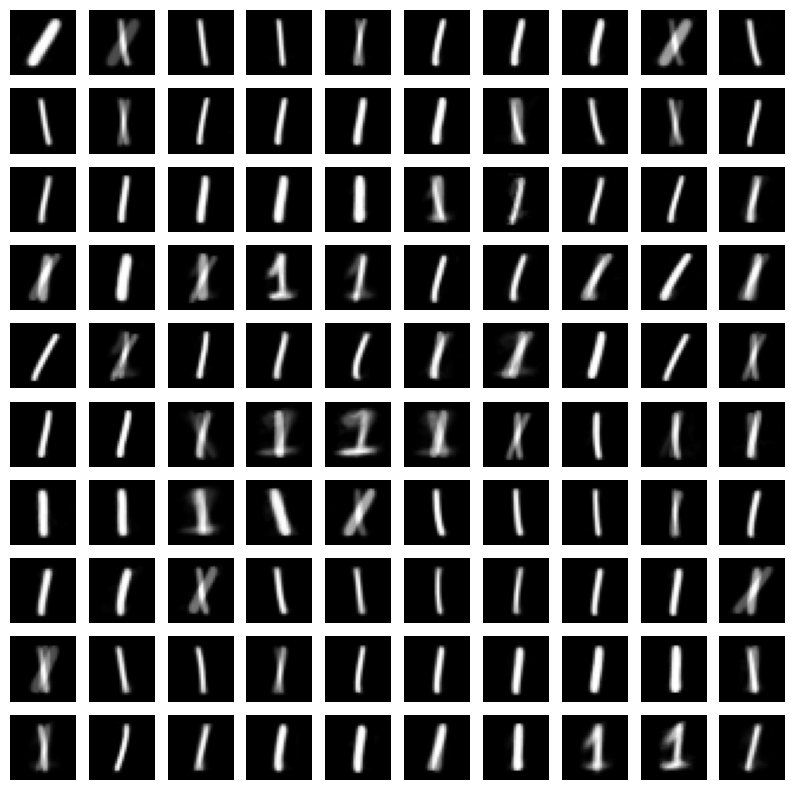

In [86]:
fig = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(result[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

In [87]:
from sklearn.neighbors import NearestNeighbors

def round_centroids(centroids, X_mnist):
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(X_mnist)

    round_centroids = np.zeros((centroids.shape[0], centroids.shape[1]))
    for centroid_id in range(centroids.shape[0]):
        centroid = centroids[centroid_id].reshape(1, -1)

        _, idx = nn.kneighbors(centroid, 1)
            
        round_centroids[centroid_id] = X_mnist[idx]
    return round_centroids

result_cpu = result.detach().cpu().numpy()
rounded_centroids = round_centroids(result_cpu, X_mnist)

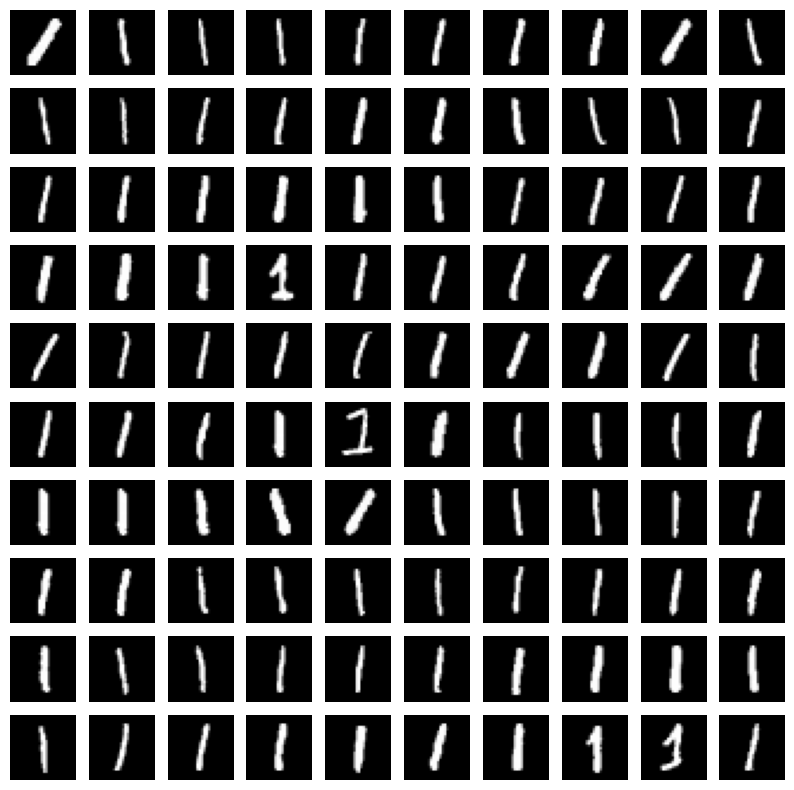

In [88]:
fig = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(rounded_centroids[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

In [89]:
flat_topology[:5]

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 0, 3],
       [0, 0, 4]])

In [90]:
X_train = flat_topology.copy()
Y_train = rounded_centroids.copy()
print(X_train.shape, Y_train.shape)

(512, 3) (512, 784)


In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

model = make_pipeline(PolynomialFeatures(3), XGBRegressor(), verbose=True)
model.fit(X_train, Y_train)

[Pipeline]  (step 1 of 2) Processing polynomialfeatures, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=   7.0s


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))],
         verbose=True)

In [92]:
data_uniform = np.random.uniform(0, 3, (X_mnist.shape[0], GRID_D))
print(data_uniform.shape)

(7877, 3)


In [93]:
generated = model.predict(data_uniform)
print(generated.shape)

(7877, 784)


In [94]:
X_train_true = X_mnist
y_train_true = np.ones((X_mnist.shape[0], 1))
X_train_false = generated
y_train_false = np.zeros((generated.shape[0], 1))

X_train = np.concatenate([X_train_true, X_train_false], axis=0)
y_train = np.concatenate([y_train_true, y_train_false], axis=0)
print(X_train.shape, y_train.shape)

(15754, 784) (15754, 1)


In [96]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.07%


/home/sahcim/dev/uwr-data-science-master/deep-lab/venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
